In [1]:
# Gorup Member 
#Tamim Rafi Ahmed 	  2021-3-60-089
#Md. Sakib husen 	  2022-1-60-274
#Mahadi Haaan	      2021-3-60-270
#d Moynul Haque Tuhin 2021-1-60-062

In [2]:
!pip install torchinfo 

In [3]:
!ls /kaggle/input/datasets/fernando2rad/brain-tumor-mri-images-44c

'Astrocitoma T1'      'Glioblastoma T1'      '_NORMAL T1'
'Astrocitoma T1C+'    'Glioblastoma T1C+'    '_NORMAL T2'
'Astrocitoma T2'      'Glioblastoma T2'      'Oligodendroglioma T1'
'Carcinoma T1'	      'Granuloma T1'	     'Oligodendroglioma T1C+'
'Carcinoma T1C+'      'Granuloma T1C+'	     'Oligodendroglioma T2'
'Carcinoma T2'	      'Granuloma T2'	     'Papiloma T1'
'Ependimoma T1'       'Meduloblastoma T1'    'Papiloma T1C+'
'Ependimoma T1C+'     'Meduloblastoma T1C+'  'Papiloma T2'
'Ependimoma T2'       'Meduloblastoma T2'    'Schwannoma T1'
'Ganglioglioma T1'    'Meningioma T1'	     'Schwannoma T1C+'
'Ganglioglioma T1C+'  'Meningioma T1C+'      'Schwannoma T2'
'Ganglioglioma T2'    'Meningioma T2'	     'Tuberculoma T1'
'Germinoma T1'	      'Neurocitoma T1'	     'Tuberculoma T1C+'
'Germinoma T1C+'      'Neurocitoma T1C+'     'Tuberculoma T2'
'Germinoma T2'	      'Neurocitoma T2'


# Imports Libraries

In [4]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
import torch
from torch import nn
import torchvision.models as models
import torch.optim as optim
from tqdm.notebook import tqdm
from torchinfo import summary
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import psutil
import random
from PIL import Image

# Configration 

In [5]:
import platform
import psutil
import subprocess


cpu_info = platform.processor()


ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)


try:
    gpu_info = subprocess.check_output(
        ["nvidia-smi", "--query-gpu=gpu_name", "--format=csv,noheader"],
        encoding="utf-8"
    )
    gpu_name = gpu_info.strip()
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


# variable

In [6]:
import os
import random
import torch
import numpy as np

seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
np.random.seed(seed)
random.seed(seed)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


data_dir = "/kaggle/input/datasets/fernando2rad/brain-tumor-mri-images-44c"
output_dir = "/kaggle/working/processed-dataset"
checkpoints_path = "/kaggle/working/"


os.makedirs(output_dir, exist_ok=True)
os.makedirs(checkpoints_path, exist_ok=True)


train_batch = 32
test_batch = 16
total_class = 3
learning_rate = 0.0001
weight_decay = 1e-4
num_epochs = 5
patience = 100

print(f"Train batch: {train_batch}, Test batch: {test_batch}")
print(f"Total classes: {total_class}")
print(f"Learning rate: {learning_rate}, Weight decay: {weight_decay}")
print(f"Epochs: {num_epochs}, Early stopping patience: {patience}")

Device: cuda
Train batch: 32, Test batch: 16
Total classes: 3
Learning rate: 0.0001, Weight decay: 0.0001
Epochs: 5, Early stopping patience: 100


# Explore Dataset

In [7]:
import os


data_dir = "/kaggle/input/datasets/fernando2rad/brain-tumor-mri-images-44c"

def load_split(split_dir):
    import pandas as pd
    file_paths, labels = [], []
    for class_name in sorted(os.listdir(split_dir)):
        class_dir = os.path.join(split_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                    file_paths.append(os.path.join(class_dir, image_name))
                    labels.append(class_name)
    return pd.DataFrame({"file_path": file_paths, "label": labels})


data = load_split(data_dir)

print(data.head())
print(f"Total images loaded: {len(data)}")
print(f"Classes found: {data['label'].unique()}")

                                           file_path           label
0  /kaggle/input/datasets/fernando2rad/brain-tumo...  Astrocitoma T1
1  /kaggle/input/datasets/fernando2rad/brain-tumo...  Astrocitoma T1
2  /kaggle/input/datasets/fernando2rad/brain-tumo...  Astrocitoma T1
3  /kaggle/input/datasets/fernando2rad/brain-tumo...  Astrocitoma T1
4  /kaggle/input/datasets/fernando2rad/brain-tumo...  Astrocitoma T1
Total images loaded: 4478
Classes found: ['Astrocitoma T1' 'Astrocitoma T1C+' 'Astrocitoma T2' 'Carcinoma T1'
 'Carcinoma T1C+' 'Carcinoma T2' 'Ependimoma T1' 'Ependimoma T1C+'
 'Ependimoma T2' 'Ganglioglioma T1' 'Ganglioglioma T1C+'
 'Ganglioglioma T2' 'Germinoma T1' 'Germinoma T1C+' 'Germinoma T2'
 'Glioblastoma T1' 'Glioblastoma T1C+' 'Glioblastoma T2' 'Granuloma T1'
 'Granuloma T1C+' 'Granuloma T2' 'Meduloblastoma T1' 'Meduloblastoma T1C+'
 'Meduloblastoma T2' 'Meningioma T1' 'Meningioma T1C+' 'Meningioma T2'
 'Neurocitoma T1' 'Neurocitoma T1C+' 'Neurocitoma T2'
 'Oligodendro

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split


train_dataframe, temp_dataframe = train_test_split(
    data,
    test_size=0.30,  
    stratify=data['label'], 
    random_state=42
)


validation_dataframe, test_dataframe = train_test_split(
    temp_dataframe,
    test_size=0.50, 
    stratify=temp_dataframe['label'], 
    random_state=42
)


print("Training set size:", len(train_dataframe))
print("Validation set size:", len(validation_dataframe))
print("Test set size:", len(test_dataframe))


print("\nClass distribution in Train set:\n", train_dataframe['label'].value_counts())
print("\nClass distribution in Validation set:\n", validation_dataframe['label'].value_counts())
print("\nClass distribution in Test set:\n", test_dataframe['label'].value_counts())

Training set size: 3134
Validation set size: 672
Test set size: 672

Class distribution in Train set:
 label
Meningioma T1C+           258
_NORMAL T2                190
Meningioma T1             190
_NORMAL T1                176
Meningioma T2             163
Astrocitoma T1C+          162
Neurocitoma T1C+          156
Schwannoma T1C+           136
Astrocitoma T1            123
Astrocitoma T2            120
Schwannoma T1             104
Neurocitoma T1             91
Schwannoma T2              86
Carcinoma T1C+             78
Papiloma T1C+              76
Neurocitoma T2             73
Glioblastoma T1C+          66
Oligodendroglioma T1       60
Tuberculoma T1C+           59
Carcinoma T2               51
Oligodendroglioma T1C+     50
Meduloblastoma T1C+        47
Carcinoma T1               46
Oligodendroglioma T2       46
Papiloma T1                46
Papiloma T2                44
Ependimoma T2              40
Glioblastoma T1            38
Glioblastoma T2            38
Ependimoma T1C+      

Total images loaded: 4479
label
Meningioma T1C+           369
Meningioma T1             272
_NORMAL T2                271
_NORMAL T1                251
Astrocitoma T1C+          233
Meningioma T2             233
Neurocitoma T1C+          223
Schwannoma T1C+           194
Astrocitoma T1            176
Astrocitoma T2            171
Schwannoma T1             148
Neurocitoma T1            130
Schwannoma T2             123
Carcinoma T1C+            112
Papiloma T1C+             108
Neurocitoma T2            104
Glioblastoma T1C+          94
Oligodendroglioma T1       86
Tuberculoma T1C+           84
Carcinoma T2               73
Oligodendroglioma T1C+     72
Meduloblastoma T1C+        67
Papiloma T1                66
Oligodendroglioma T2       66
Carcinoma T1               66
Papiloma T2                63
Ependimoma T2              57
Glioblastoma T2            55
Glioblastoma T1            55
Ependimoma T1C+            48
Ependimoma T1              45
Meduloblastoma T2          41
Germinom

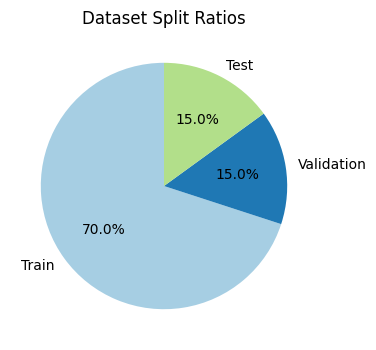

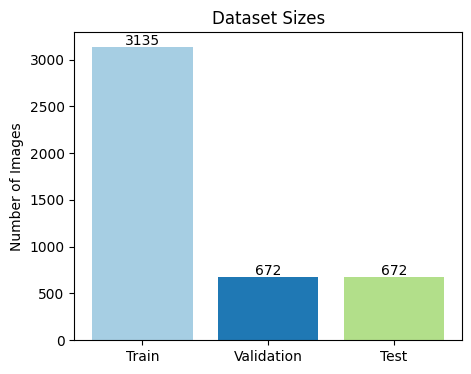

In [9]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


data_dir = "/kaggle/input/datasets/fernando2rad/brain-tumor-mri-images-44c"
if not os.path.exists(data_dir):
    raise ValueError(f"Dataset path does not exist: {data_dir}")


def load_split(split_dir):
    file_paths, labels = [], []
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                file_paths.append(os.path.join(class_dir, image_name))
                labels.append(class_name)
    return pd.DataFrame({"file_path": file_paths, "label": labels})

data = load_split(data_dir)
print(f"Total images loaded: {len(data)}")
print(data['label'].value_counts())


train_dataframe, temp_dataframe = train_test_split(
    data,
    test_size=0.30,
    stratify=data['label'],
    random_state=42
)

validation_dataframe, test_dataframe = train_test_split(
    temp_dataframe,
    test_size=0.50,
    stratify=temp_dataframe['label'],
    random_state=42
)


sizes = {
    "Train": len(train_dataframe),
    "Validation": len(validation_dataframe),
    "Test": len(test_dataframe)
}

total = sum(sizes.values())
ratios = {k: (v / total) * 100 for k, v in sizes.items()}


print("Dataset Split Ratios")
for split in sizes.keys():
    print(f"{split}: {sizes[split]} images ({ratios[split]:.2f}%)")


plt.figure(figsize=(4, 4))
plt.pie(
    sizes.values(),
    labels=sizes.keys(),
    autopct="%.1f%%",
    startangle=90,
    colors=["#a6cee3", "#1f78b4", "#b2df8a"]
)
plt.title("Dataset Split Ratios")
plt.show()

# -----------------------------
# Bar chart
# -----------------------------
plt.figure(figsize=(5, 4))
plt.bar(
    sizes.keys(),
    sizes.values(),
    color=["#a6cee3", "#1f78b4", "#b2df8a"]
)
plt.ylabel("Number of Images")
plt.title("Dataset Sizes")

y_max = max(sizes.values()) * 1.05
plt.ylim(0, y_max)

for i, v in enumerate(sizes.values()):
    plt.text(i, v + total * 0.005, str(v), ha='center')

plt.show()

Total images loaded: 4479
label
Meningioma T1C+           369
Meningioma T1             272
_NORMAL T2                271
_NORMAL T1                251
Astrocitoma T1C+          233
Meningioma T2             233
Neurocitoma T1C+          223
Schwannoma T1C+           194
Astrocitoma T1            176
Astrocitoma T2            171
Schwannoma T1             148
Neurocitoma T1            130
Schwannoma T2             123
Carcinoma T1C+            112
Papiloma T1C+             108
Neurocitoma T2            104
Glioblastoma T1C+          94
Oligodendroglioma T1       86
Tuberculoma T1C+           84
Carcinoma T2               73
Oligodendroglioma T1C+     72
Meduloblastoma T1C+        67
Papiloma T1                66
Oligodendroglioma T2       66
Carcinoma T1               66
Papiloma T2                63
Ependimoma T2              57
Glioblastoma T2            55
Glioblastoma T1            55
Ependimoma T1C+            48
Ependimoma T1              45
Meduloblastoma T2          41
Germinom

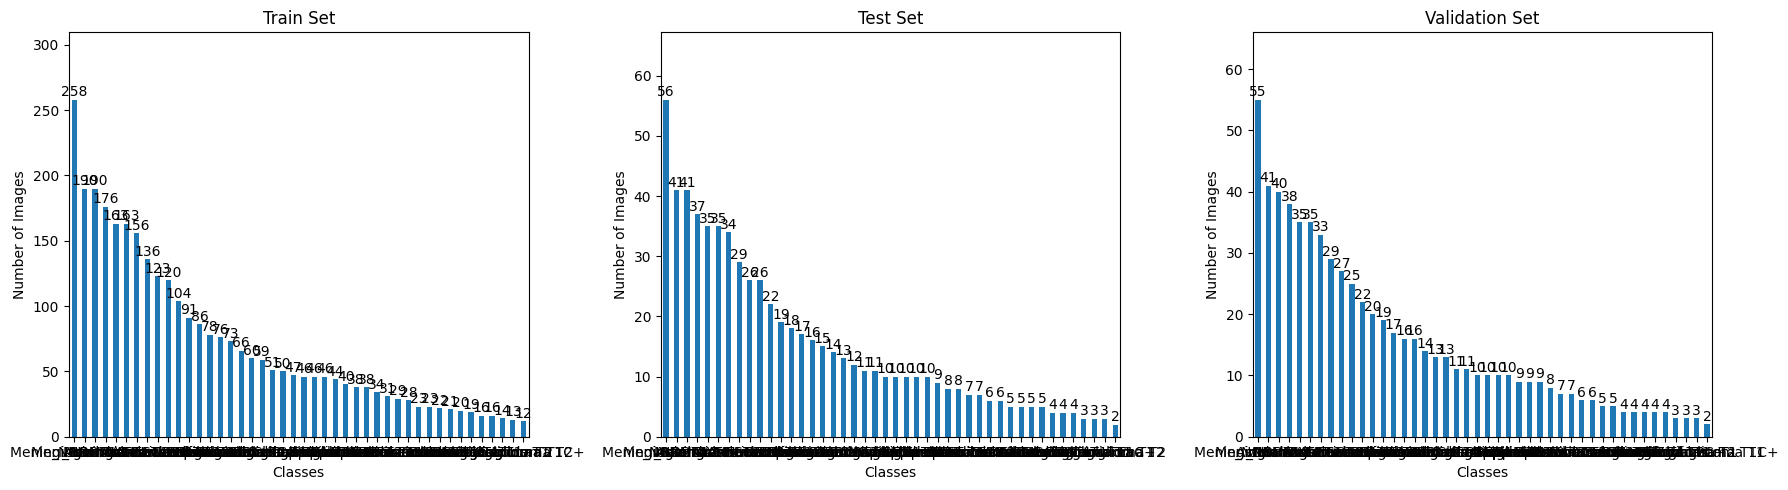

In [10]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


data_dir = "/kaggle/input/datasets/fernando2rad/brain-tumor-mri-images-44c"  # Update with your dataset path
if not os.path.exists(data_dir):
    raise ValueError(f"Dataset path does not exist: {data_dir}")


def load_dataset(split_dir):
    file_paths = []
    labels = []
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if os.path.isdir(class_dir):
            for img in os.listdir(class_dir):
                file_paths.append(os.path.join(class_dir, img))
                labels.append(class_name)
    return pd.DataFrame({"file_path": file_paths, "label": labels})

data = load_dataset(data_dir)
print(f"Total images loaded: {len(data)}")
print(data['label'].value_counts())


train_dataframe, temp_dataframe = train_test_split(
    data,
    test_size=0.30,
    stratify=data['label'],
    random_state=42
)

validation_dataframe, test_dataframe = train_test_split(
    temp_dataframe,
    test_size=0.50,
    stratify=temp_dataframe['label'],
    random_state=42
)


def class_distribution(train_df, test_df, val_df):
    datasets = {
        "Train": train_df,
        "Test": test_df,
        "Validation": val_df
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for ax, (split_name, df) in zip(axes, datasets.items()):
        class_counts = df['label'].value_counts()
        class_counts.plot(kind='bar', ax=ax, color="#1f78b4")
        ax.set_xlabel('Classes')
        ax.set_ylabel('Number of Images')
        ax.set_title(f'{split_name} Set')
        ax.set_xticks(range(len(class_counts)))
        ax.set_xticklabels(class_counts.index, rotation=0)
        
        # Add counts above bars
        for i, count in enumerate(class_counts):
            ax.text(i, count + max(class_counts)*0.01, str(count), ha='center')
        
        ax.set_ylim(0, max(class_counts) * 1.2)
    
    plt.tight_layout()
    plt.show()


class_distribution(train_dataframe, test_dataframe, validation_dataframe)

In [11]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


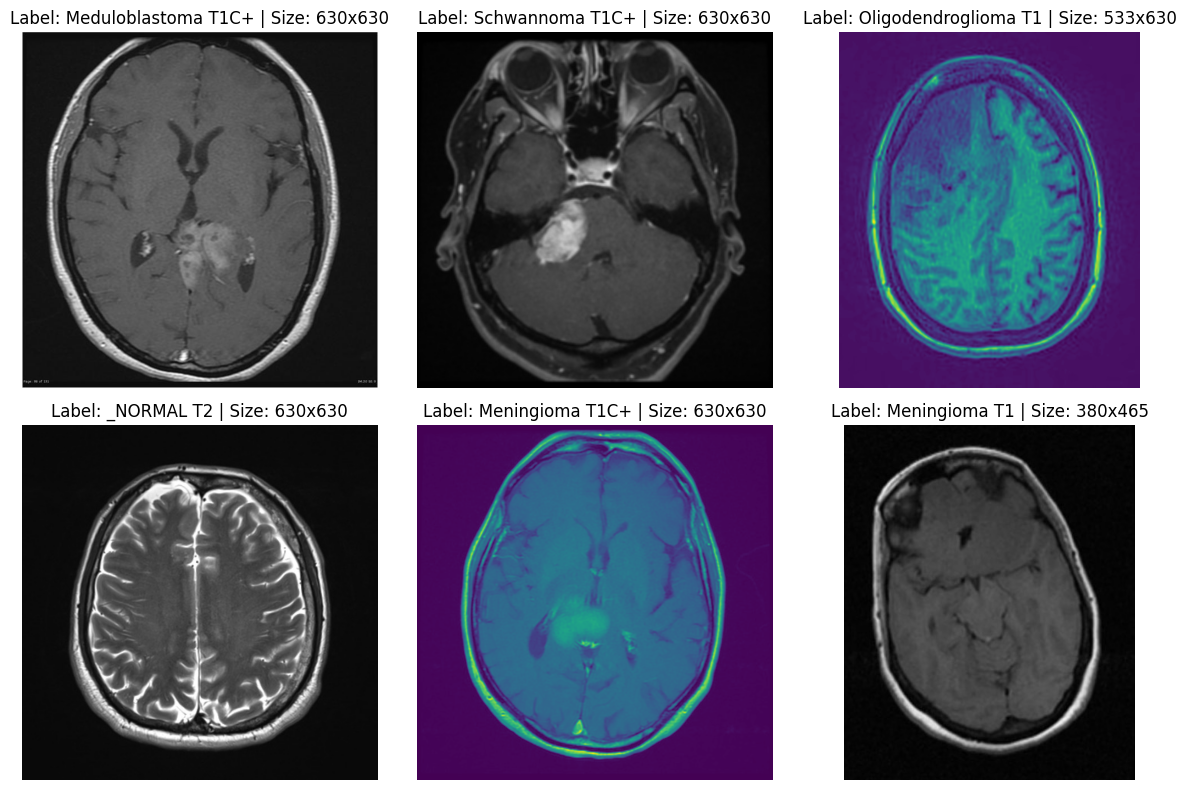

In [12]:

import random
import matplotlib.pyplot as plt
from PIL import Image  

fig, axes = plt.subplots(2, 3, figsize=(12, 8)) 
axes = axes.flatten()  

for ax in axes:
    
    random_index = random.randint(0, len(train_dataframe) - 1)
    random_row = train_dataframe.iloc[random_index]

    file_path = random_row['file_path']
    label = random_row['label']

    image = Image.open(file_path)
    width, height = image.size

    # plot image
    ax.imshow(image)
    ax.set_title(f"Label: {label} | Size: {width}x{height}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Data preprocessing 

In [13]:

from PIL import Image  
sample_image_path = train_dataframe['file_path'].iloc[0]  


img = Image.open(sample_image_path)


num_channels = len(img.getbands())  

print(f"Image path: {sample_image_path}")
print(f"Image size: {img.size}")  
print(f"Number of channels: {num_channels}")

Image path: /kaggle/input/datasets/fernando2rad/brain-tumor-mri-images-44c/Meningioma T1/a688242eaa94f0ed798ccc2520f549_big_gallery.jpg
Image size: (630, 630)
Number of channels: 3


# Dataset Class, Data Transform and Dataloader

In [14]:

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd


data_dir = "/kaggle/input/datasets/fernando2rad/brain-tumor-mri-images-44c"


file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            if file_name.endswith((".jpg", ".jpeg", ".png")):
                file_paths.append(os.path.join(class_dir, file_name))
                labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
print("Total images loaded:", len(df))
print(df['label'].value_counts())


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


class ImageDataset(Dataset):
    def __init__(self, dataframe, transform, is_lb=False):
        self.dataframe = dataframe
        self.transform = transform
        self.is_lb = is_lb
        unique_labels = sorted(self.dataframe['label'].unique())
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return image, label
        else:
            return image, image


dataset = ImageDataset(df, transform, is_lb=True)
loader = DataLoader(dataset, batch_size=4, shuffle=True)


for images, labels in loader:
    print(images.shape)  
    print(labels)        
    break

Total images loaded: 4465
label
Meningioma T1C+           369
Meningioma T1             272
_NORMAL T2                271
_NORMAL T1                251
Meningioma T2             233
Astrocitoma T1C+          232
Neurocitoma T1C+          223
Schwannoma T1C+           194
Astrocitoma T1            176
Astrocitoma T2            171
Schwannoma T1             148
Neurocitoma T1            130
Schwannoma T2             123
Carcinoma T1C+            111
Papiloma T1C+             108
Neurocitoma T2            104
Glioblastoma T1C+          94
Oligodendroglioma T1       86
Tuberculoma T1C+           84
Carcinoma T2               72
Oligodendroglioma T1C+     72
Meduloblastoma T1C+        67
Papiloma T1                66
Oligodendroglioma T2       66
Carcinoma T1               65
Papiloma T2                63
Ependimoma T2              57
Glioblastoma T2            55
Glioblastoma T1            55
Ependimoma T1C+            48
Ependimoma T1              45
Meduloblastoma T2          41
Germinom

In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

def data_transform(train_df, val_df, test_df, train_batch=32, test_batch=16):

    
    transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

   
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    
    train_dataset = ImageDataset(train_df, train_transform, is_lb=True)
    valid_dataset = ImageDataset(val_df, transform, is_lb=True)
    test_dataset  = ImageDataset(test_df, transform, is_lb=True)

    
    print("Label encoding:")
    for label, idx in train_dataset.label_map.items():
        print(f"{label} -> {idx}")

    
    train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=0)
    val_loader   = DataLoader(valid_dataset, batch_size=test_batch, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader

# Example usage
train_dataloader, validation_dataloader, test_dataloader = data_transform(
    train_dataframe, validation_dataframe, test_dataframe, train_batch=32, test_batch=16
)

Label encoding:
Astrocitoma T1 -> 0
Astrocitoma T1C+ -> 1
Astrocitoma T2 -> 2
Carcinoma T1 -> 3
Carcinoma T1C+ -> 4
Carcinoma T2 -> 5
Ependimoma T1 -> 6
Ependimoma T1C+ -> 7
Ependimoma T2 -> 8
Ganglioglioma T1 -> 9
Ganglioglioma T1C+ -> 10
Ganglioglioma T2 -> 11
Germinoma T1 -> 12
Germinoma T1C+ -> 13
Germinoma T2 -> 14
Glioblastoma T1 -> 15
Glioblastoma T1C+ -> 16
Glioblastoma T2 -> 17
Granuloma T1 -> 18
Granuloma T1C+ -> 19
Granuloma T2 -> 20
Meduloblastoma T1 -> 21
Meduloblastoma T1C+ -> 22
Meduloblastoma T2 -> 23
Meningioma T1 -> 24
Meningioma T1C+ -> 25
Meningioma T2 -> 26
Neurocitoma T1 -> 27
Neurocitoma T1C+ -> 28
Neurocitoma T2 -> 29
Oligodendroglioma T1 -> 30
Oligodendroglioma T1C+ -> 31
Oligodendroglioma T2 -> 32
Papiloma T1 -> 33
Papiloma T1C+ -> 34
Papiloma T2 -> 35
Schwannoma T1 -> 36
Schwannoma T1C+ -> 37
Schwannoma T2 -> 38
Tuberculoma T1 -> 39
Tuberculoma T1C+ -> 40
Tuberculoma T2 -> 41
_NORMAL T1 -> 42
_NORMAL T2 -> 43


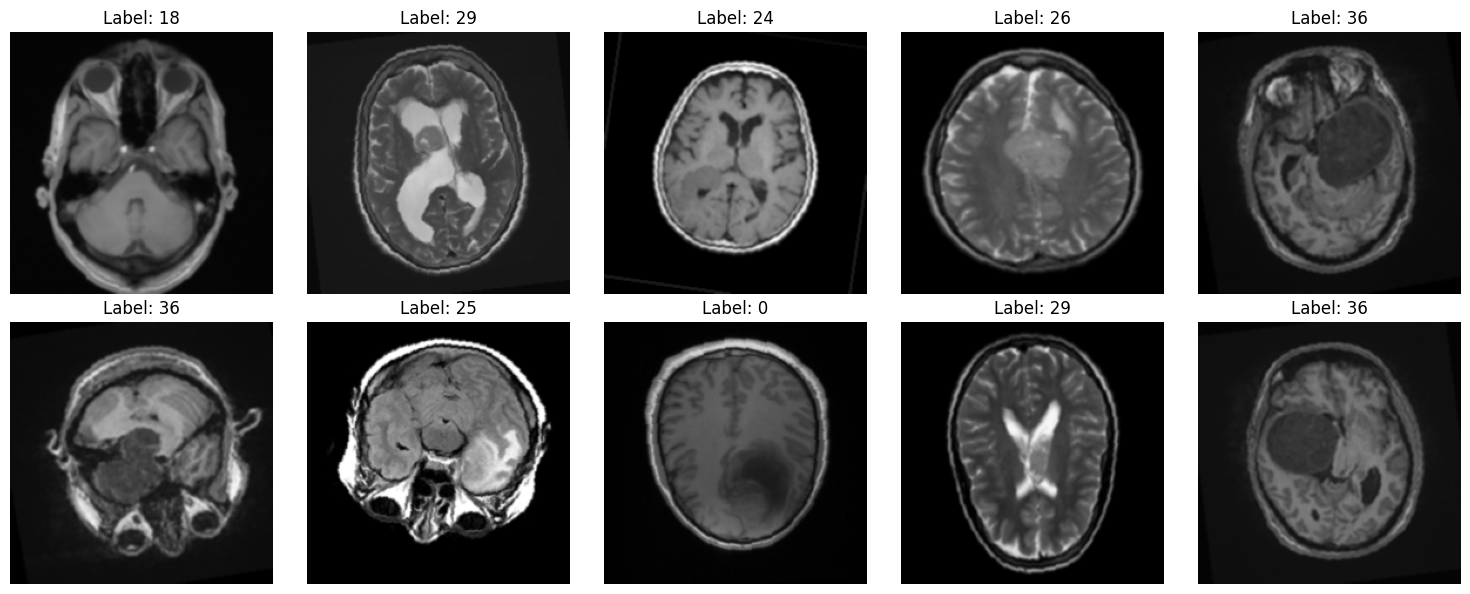

In [16]:
import torch
import matplotlib.pyplot as plt

def augmented_samples(dataloader, num_images=10):
    # Get a single batch
    images, labels = next(iter(dataloader))  

    # Move to CPU and unnormalize
    images = images.cpu()
    labels = labels.cpu()
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

    images = images * std + mean
    images = torch.clamp(images, 0, 1)

    # Plot images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i >= num_images:
            ax.axis('off')
            continue
        img = images[i].permute(1, 2, 0).numpy()  # Convert to HWC for plotting
        label = labels[i].item() if torch.is_tensor(labels[i]) else labels[i]
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


augmented_samples(train_dataloader, num_images=10)

# Deep Learning Model

In [17]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary


total_class = 3          
train_batch = 32         
learning_rate = 1e-4    
decay = 1e-4             
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  


model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)
model = model.to(device)  


optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
criterion = nn.CrossEntropyLoss()


summary(model, input_size=(3, 224, 224), batch_size=train_batch)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,096
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]          16,384
      BatchNorm2d-12          [32, 256, 56, 56]             512
           Conv2d-13          [32, 256, 56, 56]          16,384
      BatchNorm2d-14          [32, 256,

# Model Training

In [34]:
import os
import pandas as pd


data_dir = "/kaggle/input/datasets/fernando2rad/brain-tumor-mri-images-44c"

file_paths = []
labels = []


for cls in os.listdir(data_dir):
    cls_folder = os.path.join(data_dir, cls)
    if os.path.isdir(cls_folder):
        for fname in os.listdir(cls_folder):
            if fname.lower().endswith((".jpg", ".png")):
                file_paths.append(os.path.join(cls_folder, fname))
                labels.append(cls)


df = pd.DataFrame({
    "file_path": file_paths,
    "label": labels
})

print(df.head())
print(f"Total images: {len(df)} | Total classes: {df['label'].nunique()}")

                                           file_path        label
0  /kaggle/input/datasets/fernando2rad/brain-tumo...  Papiloma T2
1  /kaggle/input/datasets/fernando2rad/brain-tumo...  Papiloma T2
2  /kaggle/input/datasets/fernando2rad/brain-tumo...  Papiloma T2
3  /kaggle/input/datasets/fernando2rad/brain-tumo...  Papiloma T2
4  /kaggle/input/datasets/fernando2rad/brain-tumo...  Papiloma T2
Total images: 1266 | Total classes: 39


In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


num_epochs = 50
train_batch = 16
val_batch = 16
checkpoints_path = "checkpoints"
os.makedirs(checkpoints_path, exist_ok=True)

data_dir = "/kaggle/input/datasets/fernando2rad/brain-tumor-mri-images-44c"


file_paths = []
labels = []

for cls in os.listdir(data_dir):
    cls_folder = os.path.join(data_dir, cls)
    if os.path.isdir(cls_folder):
        for fname in os.listdir(cls_folder):
            if fname.lower().endswith((".jpg", ".png")):
                file_paths.append(os.path.join(cls_folder, fname))
                labels.append(cls)

df = pd.DataFrame({
    "file_path": file_paths,
    "label": labels
})

print(f"Total images: {len(df)}, Total classes: {df['label'].nunique()}")

train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)


train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])


class ImageDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.labels = sorted(self.dataframe['label'].unique())
        self.label_map = {label: idx for idx, label in enumerate(self.labels)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        path = self.dataframe.loc[idx, 'file_path']
        label = self.label_map[self.dataframe.loc[idx, 'label']]
        image = Image.open(path).convert("RGB")
        image = self.transform(image)
        return image, label


train_dataset = ImageDataset(train_df, train_transform)
val_dataset = ImageDataset(val_df, val_transform)

train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=val_batch, shuffle=False, num_workers=2)


model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)


for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_classes = len(df['label'].unique())
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


def train_model():
    best_val_acc = 0
    train_loss_hist, train_acc_hist = [], []
    val_loss_hist, val_acc_hist = [], []

    for epoch in range(num_epochs):

        
        model.train()
        running_loss, correct, total = 0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        train_loss_hist.append(epoch_loss)
        train_acc_hist.append(epoch_acc)

        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

        
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_correct / val_total

        val_loss_hist.append(val_epoch_loss)
        val_acc_hist.append(val_epoch_acc)

        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

       
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), f"{checkpoints_path}/best_model.pt")
            print("Best model saved.")

    return train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist



start_time = time.time()
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_model()
end_time = time.time()

print(f"Training completed in {(end_time-start_time)/60:.2f} minutes")


history_df = pd.DataFrame({
    "Epoch": list(range(1, len(train_loss_hist)+1)),
    "Train Loss": train_loss_hist,
    "Train Accuracy": train_acc_hist,
    "Validation Loss": val_loss_hist,
    "Validation Accuracy": val_acc_hist
})

history_df.to_excel('/kaggle/working/training_logs.xlsx', index=False)
print("Training logs saved successfully.")

Using device: cuda
Total images: 1266, Total classes: 39


Epoch 1/50: 100%|██████████| 64/64 [00:04<00:00, 13.30it/s]

Train Loss: 2.7381, Train Acc: 0.3162


Val Loss: 4.1447, Val Acc: 0.0236
Best model saved.


Epoch 2/50: 100%|██████████| 64/64 [00:04<00:00, 13.19it/s]

Train Loss: 1.8683, Train Acc: 0.5524


Val Loss: 4.1894, Val Acc: 0.0551
Best model saved.


Epoch 3/50: 100%|██████████| 64/64 [00:04<00:00, 13.55it/s]

Train Loss: 1.4478, Train Acc: 0.6868


Val Loss: 4.6945, Val Acc: 0.0748
Best model saved.


Epoch 4/50: 100%|██████████| 64/64 [00:04<00:00, 13.69it/s]


Train Loss: 1.1701, Train Acc: 0.7688
Val Loss: 5.0181, Val Acc: 0.0945
Best model saved.


Epoch 5/50: 100%|██████████| 64/64 [00:04<00:00, 13.21it/s]

Train Loss: 0.9812, Train Acc: 0.8063


Val Loss: 5.7791, Val Acc: 0.1220
Best model saved.


Epoch 6/50: 100%|██████████| 64/64 [00:04<00:00, 13.37it/s]

Train Loss: 0.8291, Train Acc: 0.8518


Val Loss: 5.2852, Val Acc: 0.1339
Best model saved.


Epoch 7/50: 100%|██████████| 64/64 [00:04<00:00, 13.06it/s]

Train Loss: 0.7285, Train Acc: 0.8686


Val Loss: 6.2585, Val Acc: 0.1457
Best model saved.


Epoch 8/50: 100%|██████████| 64/64 [00:04<00:00, 13.17it/s]

Train Loss: 0.6223, Train Acc: 0.9012


Val Loss: 5.6604, Val Acc: 0.1378


Epoch 9/50: 100%|██████████| 64/64 [00:04<00:00, 13.38it/s]

Train Loss: 0.5521, Train Acc: 0.9140


Val Loss: 5.9854, Val Acc: 0.1417


Epoch 10/50: 100%|██████████| 64/64 [00:04<00:00, 13.33it/s]

Train Loss: 0.5226, Train Acc: 0.9180


Val Loss: 5.7966, Val Acc: 0.1417


Epoch 11/50: 100%|██████████| 64/64 [00:04<00:00, 13.27it/s]


Train Loss: 0.4486, Train Acc: 0.9427
Val Loss: 5.7267, Val Acc: 0.1457


Epoch 12/50: 100%|██████████| 64/64 [00:04<00:00, 13.72it/s]

Train Loss: 0.4159, Train Acc: 0.9417


Val Loss: 6.8215, Val Acc: 0.1496
Best model saved.


Epoch 13/50: 100%|██████████| 64/64 [00:04<00:00, 13.52it/s]

Train Loss: 0.3737, Train Acc: 0.9516


Val Loss: 6.0095, Val Acc: 0.1417


Epoch 14/50: 100%|██████████| 64/64 [00:04<00:00, 13.50it/s]

Train Loss: 0.3568, Train Acc: 0.9585


Val Loss: 6.5503, Val Acc: 0.1457


Epoch 15/50: 100%|██████████| 64/64 [00:04<00:00, 13.59it/s]

Train Loss: 0.3201, Train Acc: 0.9664


Val Loss: 7.3596, Val Acc: 0.1614
Best model saved.


Epoch 16/50: 100%|██████████| 64/64 [00:04<00:00, 13.44it/s]

Train Loss: 0.2942, Train Acc: 0.9792


Val Loss: 6.9848, Val Acc: 0.1535


Epoch 17/50: 100%|██████████| 64/64 [00:04<00:00, 13.76it/s]

Train Loss: 0.2834, Train Acc: 0.9684


Val Loss: 6.4413, Val Acc: 0.1496


Epoch 18/50: 100%|██████████| 64/64 [00:04<00:00, 13.46it/s]


Train Loss: 0.2535, Train Acc: 0.9733
Val Loss: 6.8843, Val Acc: 0.1496


Epoch 19/50: 100%|██████████| 64/64 [00:04<00:00, 13.49it/s]

Train Loss: 0.2339, Train Acc: 0.9812


Val Loss: 8.8180, Val Acc: 0.1614


Epoch 20/50: 100%|██████████| 64/64 [00:04<00:00, 13.30it/s]

Train Loss: 0.2179, Train Acc: 0.9792


Val Loss: 7.0836, Val Acc: 0.1535


Epoch 21/50: 100%|██████████| 64/64 [00:04<00:00, 13.48it/s]

Train Loss: 0.2017, Train Acc: 0.9872


Val Loss: 7.4018, Val Acc: 0.1575


Epoch 22/50: 100%|██████████| 64/64 [00:04<00:00, 13.52it/s]

Train Loss: 0.1904, Train Acc: 0.9822


Val Loss: 7.4931, Val Acc: 0.1614


Epoch 23/50: 100%|██████████| 64/64 [00:04<00:00, 12.93it/s]

Train Loss: 0.1878, Train Acc: 0.9842


Val Loss: 6.8648, Val Acc: 0.1614


Epoch 24/50: 100%|██████████| 64/64 [00:04<00:00, 13.58it/s]

Train Loss: 0.1650, Train Acc: 0.9891


Val Loss: 6.7842, Val Acc: 0.1535


Epoch 25/50: 100%|██████████| 64/64 [00:04<00:00, 13.71it/s]

Train Loss: 0.1563, Train Acc: 0.9911


Val Loss: 8.2790, Val Acc: 0.1654
Best model saved.


Epoch 26/50: 100%|██████████| 64/64 [00:04<00:00, 13.88it/s]

Train Loss: 0.1567, Train Acc: 0.9941


Val Loss: 6.8672, Val Acc: 0.1457


Epoch 27/50: 100%|██████████| 64/64 [00:04<00:00, 13.60it/s]

Train Loss: 0.1558, Train Acc: 0.9891


Val Loss: 9.1062, Val Acc: 0.1693
Best model saved.


Epoch 28/50: 100%|██████████| 64/64 [00:04<00:00, 13.30it/s]

Train Loss: 0.1434, Train Acc: 0.9862


Val Loss: 6.2939, Val Acc: 0.1575


Epoch 29/50: 100%|██████████| 64/64 [00:04<00:00, 13.59it/s]

Train Loss: 0.1401, Train Acc: 0.9872


Val Loss: 8.0673, Val Acc: 0.1614


Epoch 30/50: 100%|██████████| 64/64 [00:04<00:00, 13.52it/s]

Train Loss: 0.1284, Train Acc: 0.9970


Val Loss: 7.4397, Val Acc: 0.1575


Epoch 31/50: 100%|██████████| 64/64 [00:04<00:00, 13.33it/s]

Train Loss: 0.1259, Train Acc: 0.9901


Val Loss: 8.2619, Val Acc: 0.1614


Epoch 32/50: 100%|██████████| 64/64 [00:04<00:00, 13.26it/s]

Train Loss: 0.1235, Train Acc: 0.9891


Val Loss: 7.6028, Val Acc: 0.1693


Epoch 33/50: 100%|██████████| 64/64 [00:04<00:00, 13.62it/s]

Train Loss: 0.1113, Train Acc: 0.9951


Val Loss: 7.6549, Val Acc: 0.1772
Best model saved.


Epoch 34/50: 100%|██████████| 64/64 [00:04<00:00, 13.45it/s]

Train Loss: 0.0984, Train Acc: 0.9951


Val Loss: 7.7660, Val Acc: 0.1614


Epoch 35/50: 100%|██████████| 64/64 [00:04<00:00, 13.95it/s]

Train Loss: 0.1178, Train Acc: 0.9911


Val Loss: 9.2403, Val Acc: 0.1732


Epoch 36/50: 100%|██████████| 64/64 [00:04<00:00, 13.53it/s]

Train Loss: 0.0939, Train Acc: 0.9980


Val Loss: 9.1654, Val Acc: 0.1693


Epoch 37/50: 100%|██████████| 64/64 [00:04<00:00, 13.74it/s]

Train Loss: 0.0962, Train Acc: 0.9941


Val Loss: 7.7027, Val Acc: 0.1693


Epoch 38/50: 100%|██████████| 64/64 [00:04<00:00, 13.83it/s]

Train Loss: 0.0930, Train Acc: 0.9931


Val Loss: 8.5392, Val Acc: 0.1811
Best model saved.


Epoch 39/50: 100%|██████████| 64/64 [00:04<00:00, 13.60it/s]

Train Loss: 0.0914, Train Acc: 0.9901


Val Loss: 8.7573, Val Acc: 0.1772


Epoch 40/50: 100%|██████████| 64/64 [00:04<00:00, 13.27it/s]

Train Loss: 0.0752, Train Acc: 0.9990


Val Loss: 7.6180, Val Acc: 0.1693


Epoch 41/50: 100%|██████████| 64/64 [00:04<00:00, 13.15it/s]

Train Loss: 0.0780, Train Acc: 0.9960


Val Loss: 7.9355, Val Acc: 0.1732


Epoch 42/50: 100%|██████████| 64/64 [00:04<00:00, 13.41it/s]

Train Loss: 0.0871, Train Acc: 0.9931


Val Loss: 7.9113, Val Acc: 0.1732


Epoch 43/50: 100%|██████████| 64/64 [00:04<00:00, 13.49it/s]


Train Loss: 0.0780, Train Acc: 0.9941
Val Loss: 9.8433, Val Acc: 0.1811


Epoch 44/50: 100%|██████████| 64/64 [00:04<00:00, 13.13it/s]

Train Loss: 0.0715, Train Acc: 0.9960


Val Loss: 8.7975, Val Acc: 0.1575


Epoch 45/50: 100%|██████████| 64/64 [00:04<00:00, 13.42it/s]

Train Loss: 0.0723, Train Acc: 0.9960


Val Loss: 8.3930, Val Acc: 0.1772


Epoch 46/50: 100%|██████████| 64/64 [00:04<00:00, 13.17it/s]

Train Loss: 0.0659, Train Acc: 0.9970


Val Loss: 9.4040, Val Acc: 0.1614


Epoch 47/50: 100%|██████████| 64/64 [00:04<00:00, 13.59it/s]


Train Loss: 0.0639, Train Acc: 0.9941
Val Loss: 9.7860, Val Acc: 0.1732


Epoch 48/50: 100%|██████████| 64/64 [00:04<00:00, 13.02it/s]

Train Loss: 0.0588, Train Acc: 0.9990


Val Loss: 9.6258, Val Acc: 0.1772


Epoch 49/50: 100%|██████████| 64/64 [00:04<00:00, 12.85it/s]


Train Loss: 0.0634, Train Acc: 0.9990
Val Loss: 9.6110, Val Acc: 0.1575


Epoch 50/50: 100%|██████████| 64/64 [00:04<00:00, 12.91it/s]

Train Loss: 0.0540, Train Acc: 0.9980


Val Loss: 8.4578, Val Acc: 0.1732
Training completed in 5.15 minutes
Training logs saved successfully.


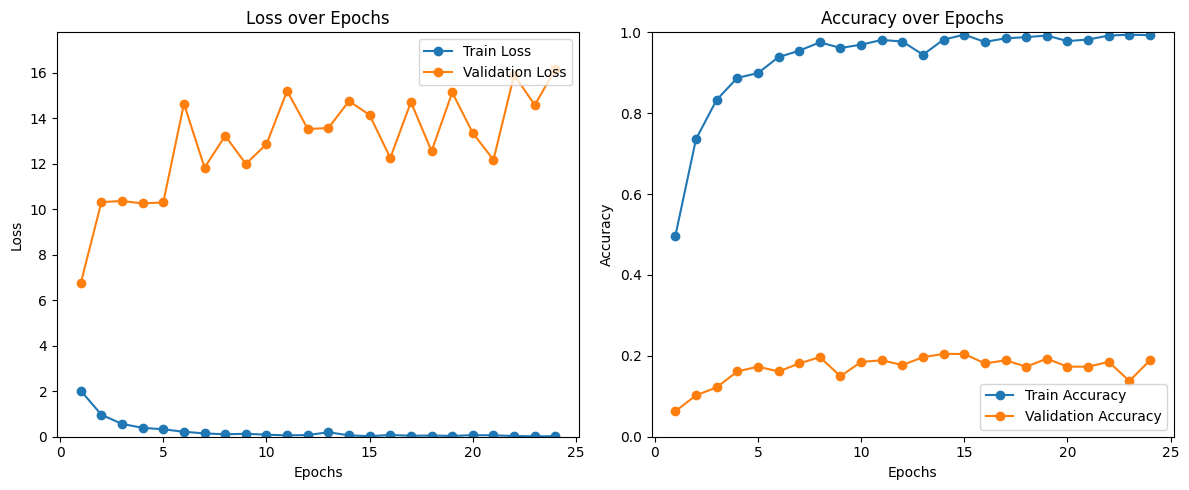

In [36]:
import matplotlib.pyplot as plt



plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_hist)+1), train_loss_hist, label='Train Loss', marker='o')
plt.plot(range(1, len(val_loss_hist)+1), val_loss_hist, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')
plt.ylim(0, max(max(train_loss_hist), max(val_loss_hist))*1.1)


plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc_hist)+1), train_acc_hist, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_acc_hist)+1), val_acc_hist, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')
plt.ylim(0, 1.0)  

plt.tight_layout()
plt.show()

# Load Saved Checkpoints

In [40]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn


checkpoints_path = "checkpoints"
best_checkpoint_path = f"{checkpoints_path}/best_model.pt"


if not os.path.isfile(best_checkpoint_path):
    raise FileNotFoundError(f"No checkpoint found at {best_checkpoint_path}")


model.load_state_dict(torch.load(best_checkpoint_path, map_location=device))
model.to(device)
model.eval()  
print("Best model loaded successfully!")


criterion = nn.CrossEntropyLoss()


val_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():  # no gradient computation
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

val_loss /= val_total
val_acc = val_correct / val_total

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Best model loaded successfully!
Validation Loss: 14.7662
Validation Accuracy: 0.2047


# Evaluation

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset  # ✅ added


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 44)
model = model.to(device)


dummy_inputs = torch.randn(32, 3, 224, 224)
dummy_labels = torch.randint(0, 44, (32,))
val_dataset = TensorDataset(dummy_inputs, dummy_labels)
val_loader = DataLoader(val_dataset, batch_size=16)

def evaluate_model(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = correct / total

    return avg_loss, accuracy


criterion = nn.CrossEntropyLoss()
val_loss, val_acc = evaluate_model(model, criterion, val_loader, device)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Validation Loss: 4.6775, Validation Accuracy: 0.0000


In [4]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        unique_labels = sorted(list(set(labels)))
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}
        self.num_classes = len(unique_labels)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        img_path = self.file_paths[index]
        label_name = self.labels[index]
        label = self.label_map[label_name]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


data_dir = "/kaggle/input/datasets/fernando2rad/brain-tumor-mri-images-44c"

file_paths = []
labels = []

for cls in os.listdir(data_dir):
    cls_folder = os.path.join(data_dir, cls)
    if os.path.isdir(cls_folder):
        for fname in os.listdir(cls_folder):
            if fname.lower().endswith((".jpg", ".png")):
                file_paths.append(os.path.join(cls_folder, fname))
                labels.append(cls.strip())

print(f"Total images: {len(file_paths)} | Total classes: {len(set(labels))}")


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset = ImageDataset(file_paths, labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"DataLoader created with {len(dataset)} images")

Total images: 1266 | Total classes: 39
DataLoader created with 1266 images


In [8]:
from sklearn.metrics import classification_report
import numpy as np


print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    labels=range(total_class),   
    target_names=class_names,
    zero_division=0               
))

Classification Report:
              precision    recall  f1-score   support

      class0       0.00      0.00      0.00         0
      class1       0.00      0.00      0.00         2
      class2       0.00      0.00      0.00         1
      class3       0.00      0.00      0.00         0
      class4       0.00      0.00      0.00         1
      class5       0.00      0.00      0.00         1
      class6       0.00      0.00      0.00         0
      class7       0.00      0.00      0.00         0
      class8       0.00      0.00      0.00         2
      class9       0.00      0.00      0.00         0
     class10       0.00      0.00      0.00         0
     class11       0.00      0.00      0.00         4
     class12       0.00      0.00      0.00         1
     class13       0.00      0.00      0.00         3
     class14       0.00      0.00      0.00         0
     class15       0.00      0.00      0.00         1
     class16       0.00      0.00      0.00         0
    

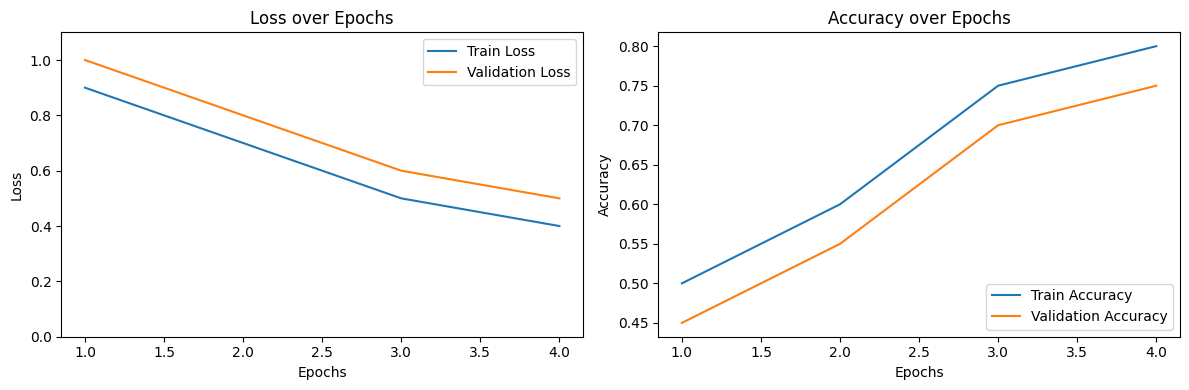

In [11]:
import matplotlib.pyplot as plt


train_loss_history = [0.9, 0.7, 0.5, 0.4]
val_loss_history   = [1.0, 0.8, 0.6, 0.5]
train_acc_history  = [0.5, 0.6, 0.75, 0.8]
val_acc_history    = [0.45, 0.55, 0.7, 0.75]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')
plt.ylim(0, max(max(train_loss_history), max(val_loss_history)) * 1.1)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

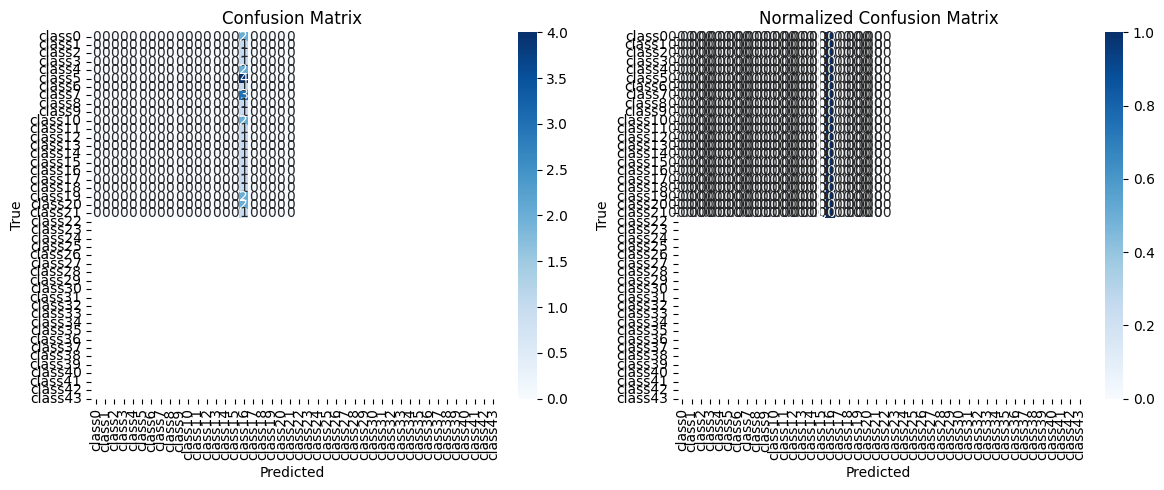

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 5))

# Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Normalized Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

In [15]:
import numpy as np
from scipy import stats


train_acc_history = np.linspace(0.5, 0.9, 20) + np.random.normal(0, 0.01, 20)
val_acc_history   = np.linspace(0.48, 0.88, 20) + np.random.normal(0, 0.01, 20)

t_stat, p_value = stats.ttest_rel(train_acc_history, val_acc_history)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Difference between training and validation accuracy is statistically significant")
else:
    print("No significant difference between training and validation accuracy")

T-statistic: 8.5774
P-value: 0.0000
Difference between training and validation accuracy is statistically significant
